# Feature Mappings for Image Reconstruction

## Setup and Visualization

In [17]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import cv2

from model import Linear , MSELoss , ReLU  , Sigmoid , Model , Identity  , Tanh
from datetime import datetime
import time
import os
from PIL import Image
USERNAME = "shubham.goel"

import pandas as pd

In [18]:
smiley_img = iio.imread('dataset/Q2/smiley.png') 
print(f"smiley_img shape: {smiley_img.shape}") 

smiley_img shape: (256, 256, 3)


In [19]:
cat_img = iio.imread('dataset/Q2/cat.jpg') 
print(f"cat_img shape: {cat_img.shape}")
cat_img = cv2.resize(cat_img, (smiley_img.shape[1], smiley_img.shape[0]))
print(f"cat_img resized shape: {cat_img.shape}")

# Save the resized image
cv2.imwrite('dataset/Q2/cat_resized.jpg', cv2.cvtColor(cat_img, cv2.COLOR_RGB2BGR))
print("Resized image saved as dataset/Q2/cat_resized.jpg")

cat_img shape: (2333, 2333, 3)
cat_img resized shape: (256, 256, 3)
Resized image saved as dataset/Q2/cat_resized.jpg


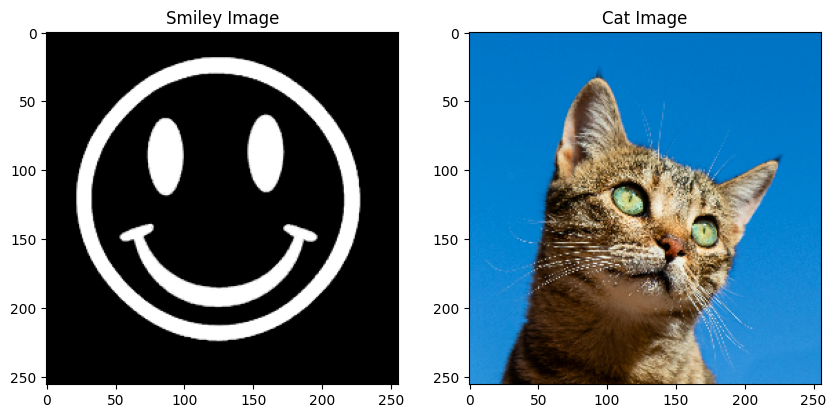

In [20]:
axes , fig = plt.subplots(1,2, figsize=(10,5))
fig[0].imshow(smiley_img)
fig[0].set_title('Smiley Image')
fig[1].imshow(cat_img)
fig[1].set_title('Cat Image')
plt.show()

## Feature Expansions

In [21]:
def get_raw(coords):
    """
    Raw coordinate mapping: γ_raw(x,y) = (x,y)
    """
    return coords



def get_polynomial(coords, order=5):
    """
    Polynomial expansion: γ_poly(x,y) = [x, y, x^2, y^2, xy, ..., x^order, y^order]
    """
    x, y = coords[:, 0], coords[:, 1]
    features = [x, y]  # Start with x and y

    # For each degree from 2 to order, add all monomials x^a y^b where a + b = degree
    for deg in range(2, order + 1):
        for a in range(deg + 1):
            b = deg - a
            features.append((x ** a) * (y ** b))

    return np.column_stack(features)



def get_fourier(coords, freq=10):
    """
    Fourier feature expansion: γ_fourier(x,y) = [1, sin(2πf₁x), cos(2πf₁x), ..., sin(2πf_k y), cos(2πf_k y)]
    """
    x, y = coords[:, 0], coords[:, 1]
    features = [np.ones_like(x)]  # Bias term

    # Generate frequency values as powers of 2
    frequencies = 2 ** np.arange(freq)

    # Add sin/cos terms for x coordinate
    for f in frequencies:
        features.append(np.sin(2 * np.pi * f * x))
        features.append(np.cos(2 * np.pi * f * x))

    # Add sin/cos terms for y coordinate
    for f in frequencies:
        features.append(np.sin(2 * np.pi * f * y))
        features.append(np.cos(2 * np.pi * f * y))

    return np.column_stack(features)

## Normalization and Modular MLP

In [22]:
class Modular_Dataloader:
    """
    Modular data loader for image reconstruction with different feature mappings.
    
    Args:
        img_path (str): Path to the image
        image_type (str): "RGB" or "Gray"
        method (str): Feature mapping - "Raw", "Polynomial", or "Fourier"
        order (int): Order for polynomial expansion
        freq (int): Number of frequencies for Fourier features
    """
    

    def __init__(self, img_path, image_type, method, order=5, freq=10):
        self.img_path = img_path
        self.image_type = image_type
        self.method = method
        self.order = order
        self.freq = freq
        
        # Load and preprocess image
        self.image_data, self.coordinates, self.targets = self._load_and_prepare_data()
        
        # Apply feature mapping with normalization
        self.features = self._apply_feature_mapping()
        
        # print(f"Dataloader initialized:")
        # print(f"  Image: {img_path}")
        # print(f"  Type: {image_type}")
        # print(f"  Method: {method}")
        # print(f"  Image shape: {self.image_data.shape}")
        # print(f"  Feature shape: {self.features.shape}")
        # print(f"  Target shape: {self.targets.shape}\n")
    


    def _load_and_prepare_data(self):
        """Load image and create coordinate-pixel pairs."""
        
        # Load image
        img = Image.open(self.img_path)
        
        if self.image_type == "Gray":
            img = img.convert('L')
            img_array = np.array(img) / 255.0
            
        elif self.image_type == "RGB":
            img = img.convert('RGB')
            img = img.resize((256, 256))
            img_array = np.array(img) / 255.0
        
        else:
            raise ValueError("image_type must be 'RGB' or 'Gray'")
        

        # Create coordinate grid
        height, width = img_array.shape[:2]
        y_coords, x_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
        

        # Normalize coordinates to [0, 1]
        x_normalized = x_coords.flatten() / (width - 1)
        y_normalized = y_coords.flatten() / (height - 1)
        coordinates = np.column_stack([x_normalized, y_normalized])
        

        # Prepare target values
        if self.image_type == "Gray":
            targets = img_array.flatten().reshape(-1, 1)
        else:  # RGB
            targets = img_array.reshape(-1, 3)
        
        return img_array, coordinates, targets
    


    def _apply_feature_mapping(self):
        """Apply the specified feature mapping with proper normalization."""
        
        if self.method == "Raw":
            features = get_raw(self.coordinates)
            

        elif self.method == "Polynomial":
            # Polynomial works best when coords are in [-1,1]
            coords_m1p1 = (self.coordinates * 2.0) - 1.0
            features = get_polynomial(coords_m1p1, order=self.order)

            # Normalize polynomial features to prevent exploding values
            features = self._normalize_features(features, fit = True)
            

        elif self.method == "Fourier":
            # Scale coordinates for Fourier features (full cycle coverage)
            features = get_fourier(self.coordinates , freq=self.freq)
            features = self._normalize_features(features, fit=True)
            # Fourier features are already in [-1, 1] range
            
        return features
    


    def _normalize_features(self, features, fit=False):
        """
        Normalize features to prevent training instabilities.
        """
        
        if fit:
            # Compute and store normalization statistics
            mean = np.mean(features, axis=0)
            std = np.std(features, axis=0) + 1e-6
            
            # Store for later use on test data
            self.feature_mean = mean
            self.feature_std = std
            
            
        else:
            # Use stored statistics (for test data)
            if not hasattr(self, 'feature_mean') or not hasattr(self, 'feature_std'):
                raise ValueError("Must fit normalization first before applying to test data")
            mean = self.feature_mean
            std = self.feature_std
        
        normalized = (features - mean) / std
        
        return normalized
    


    def get_data(self):
        """Return features and targets for training."""
        return self.features, self.targets
    

    
    def reconstruct_image(self, predictions):
        """Reconstruct image from flattened predictions."""
        
        if self.image_type == "Gray":
            return predictions.reshape(self.image_data.shape)
        else:  # RGB
            return predictions.reshape(self.image_data.shape)
    



    def get_info(self):
        """Return information about the dataloader."""
        return {
            'method': self.method,
            'image_type': self.image_type,
            'input_dim': self.features.shape[1],
            'output_dim': self.targets.shape[1],
            'num_pixels': len(self.targets),
            'order': self.order if self.method == "Polynomial" else None,
            'freq': self.freq if self.method == "Fourier" else None
        }


In [23]:
class ImageReconstructionMLP:
    """MLP specialized for image reconstruction tasks."""
    
    def __init__(self, input_dim, output_dim, hidden_sizes=[64, 128, 128], learning_rate=0.001):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_sizes = hidden_sizes
        self.learning_rate = learning_rate
        
        # Build layers
        self.layers = []
        layer_sizes = [input_dim] + hidden_sizes + [output_dim]
        
        for i in range(len(layer_sizes) - 1):
            if i == len(layer_sizes) - 2:  # Output layer
                activation = Sigmoid()  
            else:  # Hidden layers
                activation = ReLU()
            
            layer = Linear(
                layer_sizes[i], 
                layer_sizes[i+1], 
                activation, 
                learning_rate
            )
            self.layers.append(layer)
        
        self.loss_function = MSELoss()
        self.training_history = {'losses': [], 'epochs': []}
        
        print(f"MLP Architecture: {' -> '.join(map(str, layer_sizes))}")
        print(f"Total parameters: {self.get_parameter_count()}")
    


    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output
    


    def backward(self, loss_gradient):
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    


    def train_step(self, x, y):
        predictions = self.forward(x)
        loss = self.loss_function.forward(predictions, y)
        loss_gradient = self.loss_function.backward(predictions, y)
        self.backward(loss_gradient)
        return loss
    


    def predict(self, x):
        return self.forward(x)
    


    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()
    


    def update_parameters(self, gradient_accumulation_steps=1):
        for layer in self.layers:
            layer.update_parameters(gradient_accumulation_steps)
        self.zero_grad()
    

    
    def get_parameter_count(self):
        total_params = 0
        for layer in self.layers:
            total_params += layer.weights.size + layer.biases.size
        return total_params


##  Training and Comparison

In [ ]:
def train_image_reconstruction(dataloader, num_epochs, batch_size=16, save_epochs=True, dir_name="results"):
    """
    Train MLP for image reconstruction.
    
    Args:
        dataloader: Modular_Dataloader instance
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        save_epochs: Whether to save reconstructions at each epoch
    
    Returns:
        dict: Training results and saved images
    """
    
    # Get data
    features, targets = dataloader.get_data()
    info = dataloader.get_info()
    
    # Create MLP
    mlp = ImageReconstructionMLP(
        input_dim=info['input_dim'],
        output_dim=info['output_dim'],
        hidden_sizes=[64, 128, 128],
        learning_rate=0.5
    )
    

    # Training setup
    num_samples = len(features)
    losses = []
    saved_images = []
    epoch_times = []
    grad_accumulation_steps = 1
    
    print(f"Training {info['method']} method for {num_epochs} epochs...")
    
    start_total_time = time.time()
    

    for epoch in range(num_epochs):
        epoch_start = time.time()
        epoch_loss = 0
        num_batches = 0
        
        # Shuffle data
        indices = np.random.permutation(num_samples)
        
        # Mini-batch training - SAME PATTERN AS Q1
        for batch_start in range(0, num_samples, batch_size):
            batch_end = min(batch_start + batch_size, num_samples)
            batch_indices = indices[batch_start:batch_end]
            batch_features = features[batch_indices]
            batch_targets = targets[batch_indices]
            
            # Training step
            loss = mlp.train_step(batch_features, batch_targets)
            epoch_loss += loss
            num_batches += 1
            
            # Parameters will only be updated every grad_accumulation_steps
            if num_batches % grad_accumulation_steps == 0:
                mlp.update_parameters(grad_accumulation_steps)
        


        # Final update if needed (same as Q1)
        if num_batches % grad_accumulation_steps != 0:
            mlp.update_parameters(grad_accumulation_steps)
        
        # Record epoch loss
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        epoch_times.append(epoch_time)
        
        # Save reconstruction at this epoch
        if save_epochs:
            predictions = mlp.predict(features)
            reconstructed = dataloader.reconstruct_image(predictions)
            saved_images.append(reconstructed.copy())

        # save reconstructed image every epoch
        if save_epochs:
            predictions = mlp.predict(features)
            reconstructed = dataloader.reconstruct_image(predictions)
            save_path = dir_name + f"/reconstructed_epoch_{epoch+1}.png"
            os.makedirs(dir_name, exist_ok=True)
            if info['image_type'] == "Gray":
                plt.imsave(save_path, reconstructed, cmap='gray', vmin=0, vmax=1)
            else:
                plt.imsave(save_path, np.clip(reconstructed, 0, 1))
            # print(f"Saved reconstruction at epoch {epoch+1} to {save_path}")
        
        # Progress reporting
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.6f}, Time = {epoch_time:.2f}s")
    



    total_time = time.time() - start_total_time
    
    # Final predictions
    final_predictions = mlp.predict(features)
    final_reconstruction = dataloader.reconstruct_image(final_predictions)
    
    results = {
        'method': info['method'],
        'final_loss': losses[-1],
        'losses': losses,
        'final_reconstruction': final_reconstruction,
        'saved_images': saved_images,
        'total_time': total_time,
        'avg_epoch_time': np.mean(epoch_times),
        'input_parameters': info['input_dim'],
        'model_parameters': mlp.get_parameter_count(),
        'dataloader_info': info
    }
    
    print(f"Training completed! Final loss: {losses[-1]:.6f}")
    print(f"Total time: {total_time:.2f}s, Avg epoch time: {np.mean(epoch_times):.2f}s")
    
    return results

In [ ]:
def visualize_reconstruction_comparison(original, results_list, title=""):
    """
    Visualize original vs reconstructed images for multiple methods.
    Shows original image, then for each method: reconstructed image + loss curve.
    At the end, prints a comparison table.
    """

    if len(results_list) == 0:
        return

    # Show the original image
    plt.figure(figsize=(6, 6))

    if len(original.shape) == 2:  # Grayscale
        plt.imshow(original, cmap='gray')
    else:  # RGB
        plt.imshow(original)

    plt.title(f'Original Image - {title}', fontsize=14)
    plt.axis('off')
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=10, color='white', alpha=0.7)
    plt.tight_layout()
    plt.show()


    # ---------------------------------------------------------------------

    # Collect table data
    table_data = []

    # Show each reconstruction method
    for i, result in enumerate(results_list):
        reconstruction = result['final_reconstruction']
        method = result['method']
        final_loss = result['final_loss']
        losses = result['losses']
        avg_epoch_time = result.get('avg_epoch_time', None)
        input_dim = result.get('input_parameters', None)
        order = result['dataloader_info'].get('order', None)
        freq = result['dataloader_info'].get('freq', None)

        # Create figure with 2 subplots: reconstruction and loss curve
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


        # Reconstruction image
        if len(reconstruction.shape) == 2:  # Grayscale
            ax1.imshow(reconstruction, cmap='gray', vmin=0, vmax=1)
        else:  # RGB
            ax1.imshow(np.clip(reconstruction, 0, 1))


        ax1.set_title(f'{method} Reconstruction\nFinal Loss: {final_loss:.6f}', fontsize=14)
        ax1.axis('off')
        plt.text(0.95, 0.95, USERNAME, ha='right', va='top', 
                 transform=ax1.transAxes, fontsize=10, color='white', alpha=0.7)


        # Loss curve (no arrow)
        ax2.plot(losses, color='blue', linewidth=2)
        ax2.set_title(f'{method} Training Loss', fontsize=14)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(bottom=0)
        plt.text(0.95, 0.05, USERNAME, ha='right', va='bottom', 
                 transform=ax2.transAxes, fontsize=8, color='gray', alpha=0.7)

        plt.suptitle(f'{title} - {method} Results', fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"{method}: Final Loss = {final_loss:.6f}, Epochs = {len(losses)}")

        # Prepare method name for table
        if 'Polynomial' in method and order is not None:
            method_name = f'Polynomial (order={order})'
        elif 'Fourier' in method and freq is not None:
            method_name = f'Fourier (freq={freq})'
        else:
            method_name = method

        table_data.append({
            'Method': method_name,
            'Final Loss': final_loss,
            'Avg Epoch Time (s)': avg_epoch_time,
            'Input Parameters': input_dim
        })

    # Show comparison table
    print("\n\n=== MODEL COMPARISON TABLE ===")
    df = pd.DataFrame(table_data)
    print(df.to_string(index=False, float_format='%.6f'))

## Smiley image - 50 epochs

In [25]:
print("=== TRAINING ON SMILEY IMAGE ===")

# Create dataloaders for smiley
smiley_raw = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Raw')
smiley_poly5 = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Polynomial', order=5)
smiley_poly15 = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Polynomial', order=15)
smiley_poly25 = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Polynomial', order=25)
smiley_fourier5 = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Fourier', freq=5)
smiley_fourier15 = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Fourier', freq=15)
smiley_fourier25 = Modular_Dataloader('dataset/Q2/smiley.png', 'Gray', 'Fourier', freq=25)

# Train all methods
smiley_results = []

=== TRAINING ON SMILEY IMAGE ===


In [26]:
print("\n1. Training Raw method...")
result_raw = train_image_reconstruction(smiley_raw, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_raw")
smiley_results.append(result_raw)


1. Training Raw method...
MLP Architecture: 2 -> 64 -> 128 -> 128 -> 1
Total parameters: 25153
Training Raw method for 50 epochs...
Epoch 1/50: Loss = 0.069409, Time = 1.78s
Epoch 11/50: Loss = 0.065825, Time = 1.76s
Epoch 21/50: Loss = 0.063690, Time = 1.85s
Epoch 31/50: Loss = 0.059693, Time = 1.84s
Epoch 41/50: Loss = 0.051350, Time = 1.77s
Epoch 50/50: Loss = 0.046990, Time = 1.77s
Training completed! Final loss: 0.046990
Total time: 123.31s, Avg epoch time: 1.81s


In [27]:
print("\n2. Training Polynomial order=5...")
result_poly5 = train_image_reconstruction(smiley_poly5, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_poly5")
smiley_results.append(result_poly5)


2. Training Polynomial order=5...
MLP Architecture: 20 -> 64 -> 128 -> 128 -> 1
Total parameters: 26305
Training Polynomial method for 50 epochs...
Epoch 1/50: Loss = 0.059301, Time = 1.84s
Epoch 11/50: Loss = 0.011015, Time = 1.95s
Epoch 21/50: Loss = 0.005653, Time = 2.01s


/home2/shubhamcvit/smai/model.py:52: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 31/50: Loss = 0.004314, Time = 2.12s
Epoch 41/50: Loss = 0.003570, Time = 2.16s
Epoch 50/50: Loss = 0.003073, Time = 2.19s
Training completed! Final loss: 0.003073
Total time: 136.04s, Avg epoch time: 2.06s


In [28]:
print("\n3. Training Polynomial order=15...")
result_poly15 = train_image_reconstruction(smiley_poly15, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_poly15")
smiley_results.append(result_poly15)


3. Training Polynomial order=15...
MLP Architecture: 135 -> 64 -> 128 -> 128 -> 1
Total parameters: 33665
Training Polynomial method for 50 epochs...
Epoch 1/50: Loss = 0.058753, Time = 2.05s
Epoch 11/50: Loss = 0.012369, Time = 2.12s
Epoch 21/50: Loss = 0.006232, Time = 2.24s
Epoch 31/50: Loss = 0.004772, Time = 2.34s
Epoch 41/50: Loss = 0.003969, Time = 2.42s
Epoch 50/50: Loss = 0.003501, Time = 2.60s
Training completed! Final loss: 0.003501
Total time: 148.95s, Avg epoch time: 2.28s


In [29]:
print("\n4. Training Polynomial order=25...")
result_poly25 = train_image_reconstruction(smiley_poly25, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_poly25")
smiley_results.append(result_poly25)


4. Training Polynomial order=25...
MLP Architecture: 350 -> 64 -> 128 -> 128 -> 1
Total parameters: 47425
Training Polynomial method for 50 epochs...


Epoch 1/50: Loss = 0.059282, Time = 2.58s
Epoch 11/50: Loss = 0.012627, Time = 2.63s
Epoch 21/50: Loss = 0.005954, Time = 3.05s
Epoch 31/50: Loss = 0.004827, Time = 3.24s
Epoch 41/50: Loss = 0.004320, Time = 3.30s
Epoch 50/50: Loss = 0.003885, Time = 3.43s
Training completed! Final loss: 0.003885
Total time: 193.67s, Avg epoch time: 3.06s


In [30]:
print("\n5. Training Fourier freq=5...")
result_fourier5 = train_image_reconstruction(smiley_fourier5, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_fourier5")
smiley_results.append(result_fourier5)


5. Training Fourier freq=5...
MLP Architecture: 21 -> 64 -> 128 -> 128 -> 1
Total parameters: 26369
Training Fourier method for 50 epochs...
Epoch 1/50: Loss = 0.059107, Time = 1.80s
Epoch 11/50: Loss = 0.002117, Time = 1.91s
Epoch 21/50: Loss = 0.001228, Time = 1.81s


Epoch 31/50: Loss = 0.000950, Time = 1.82s
Epoch 41/50: Loss = 0.000785, Time = 1.81s
Epoch 50/50: Loss = 0.000647, Time = 1.90s
Training completed! Final loss: 0.000647
Total time: 124.84s, Avg epoch time: 1.83s


In [31]:
print("\n6. Training Fourier freq=15...")
result_fourier15 = train_image_reconstruction(smiley_fourier15, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_fourier15")
smiley_results.append(result_fourier15)


6. Training Fourier freq=15...
MLP Architecture: 61 -> 64 -> 128 -> 128 -> 1
Total parameters: 28929
Training Fourier method for 50 epochs...
Epoch 1/50: Loss = 0.058160, Time = 1.90s
Epoch 11/50: Loss = 0.002741, Time = 1.92s


Epoch 21/50: Loss = 0.001231, Time = 1.91s
Epoch 31/50: Loss = 0.000844, Time = 1.92s
Epoch 41/50: Loss = 0.000645, Time = 1.90s
Epoch 50/50: Loss = 0.000463, Time = 1.92s
Training completed! Final loss: 0.000463
Total time: 130.00s, Avg epoch time: 1.91s


In [32]:

print("\n7. Training Fourier freq=25...")
result_fourier25 = train_image_reconstruction(smiley_fourier25, num_epochs=50, batch_size=16, save_epochs=True, dir_name="results/smiley_fourier25")
smiley_results.append(result_fourier25)


7. Training Fourier freq=25...
MLP Architecture: 101 -> 64 -> 128 -> 128 -> 1
Total parameters: 31489
Training Fourier method for 50 epochs...
Epoch 1/50: Loss = 0.056694, Time = 2.00s
Epoch 11/50: Loss = 0.002284, Time = 1.99s


Epoch 21/50: Loss = 0.001153, Time = 2.01s
Epoch 31/50: Loss = 0.000818, Time = 2.01s
Epoch 41/50: Loss = 0.000686, Time = 2.02s
Epoch 50/50: Loss = 0.000497, Time = 1.99s
Training completed! Final loss: 0.000497
Total time: 136.82s, Avg epoch time: 2.02s


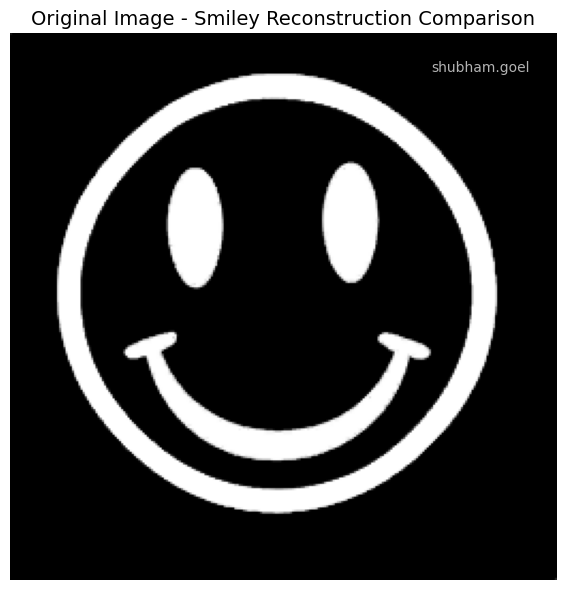

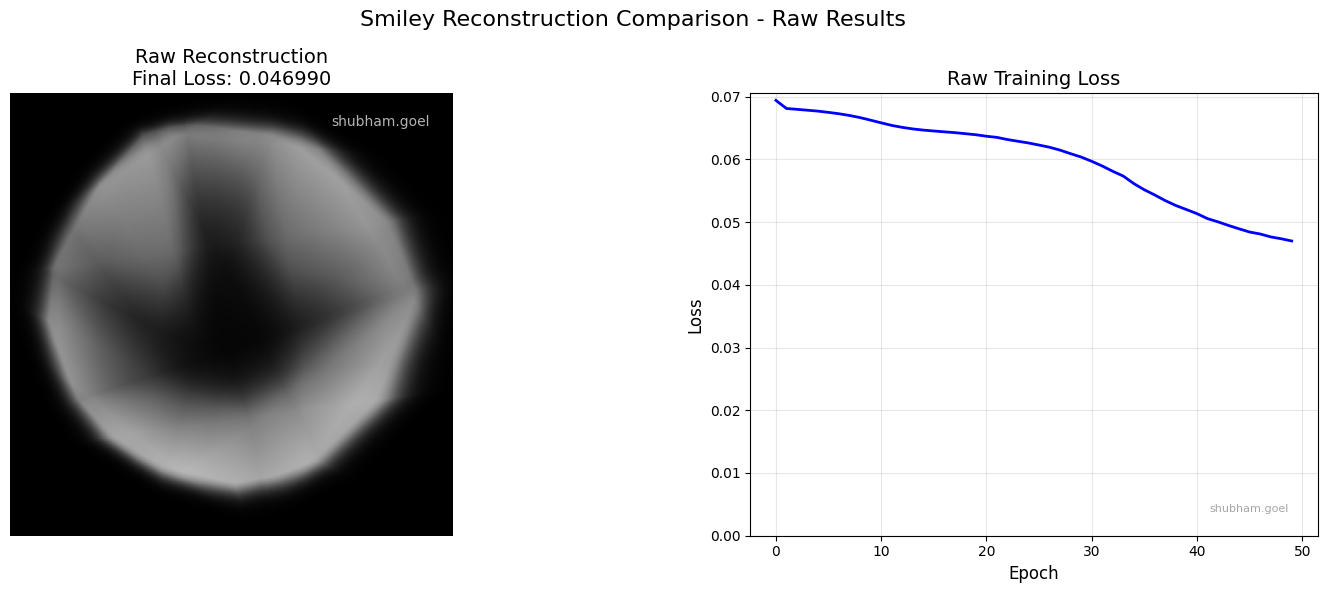

Raw: Final Loss = 0.046990, Epochs = 50


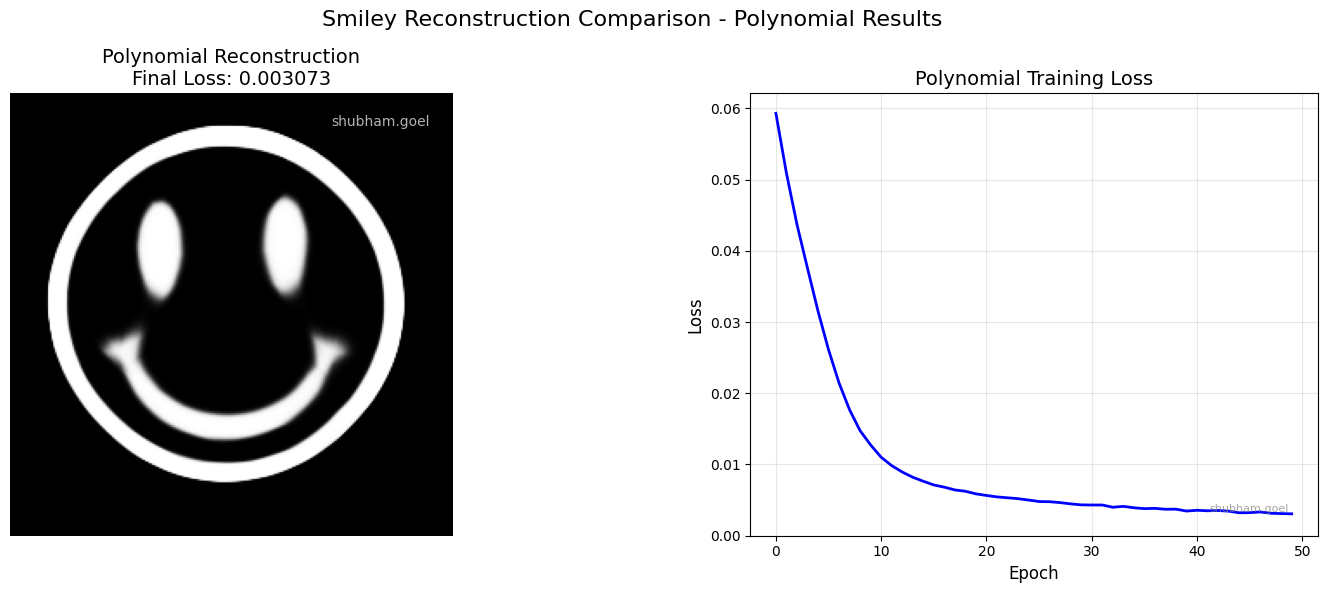

Polynomial: Final Loss = 0.003073, Epochs = 50


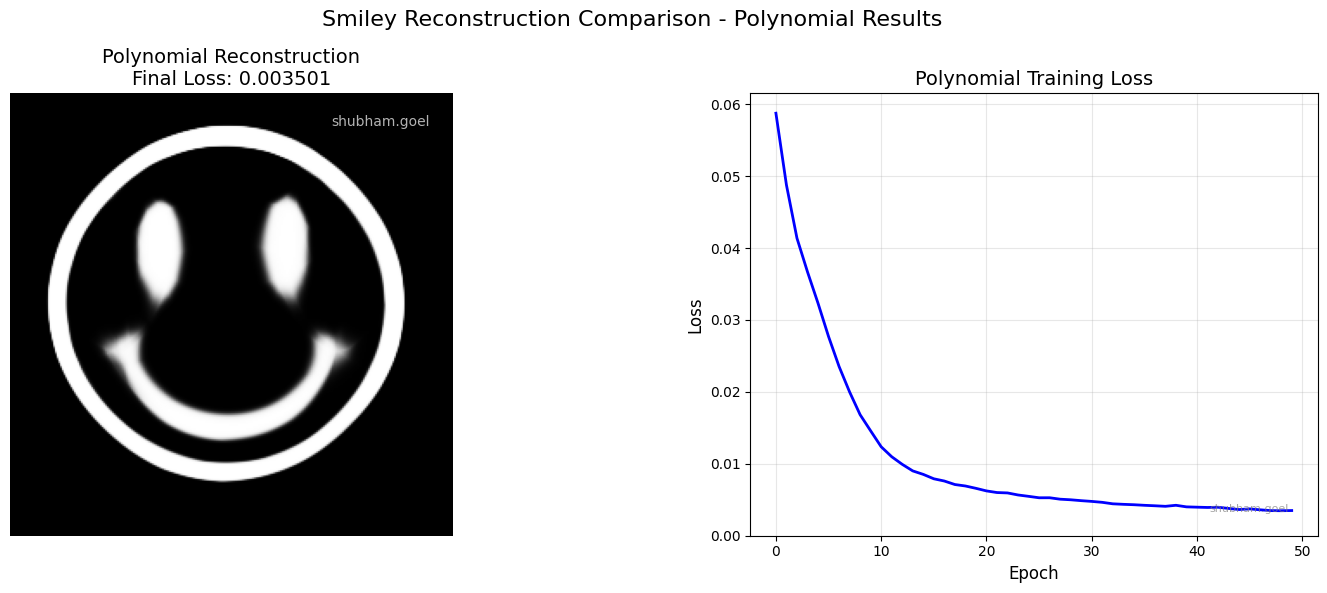

Polynomial: Final Loss = 0.003501, Epochs = 50


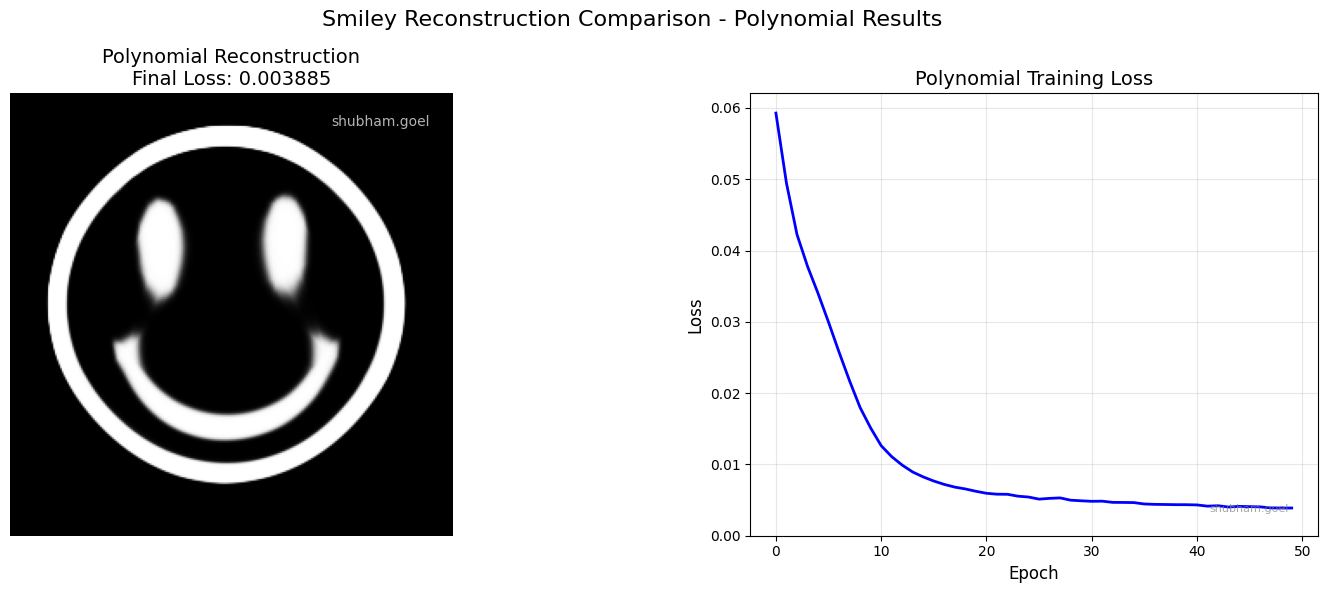

Polynomial: Final Loss = 0.003885, Epochs = 50


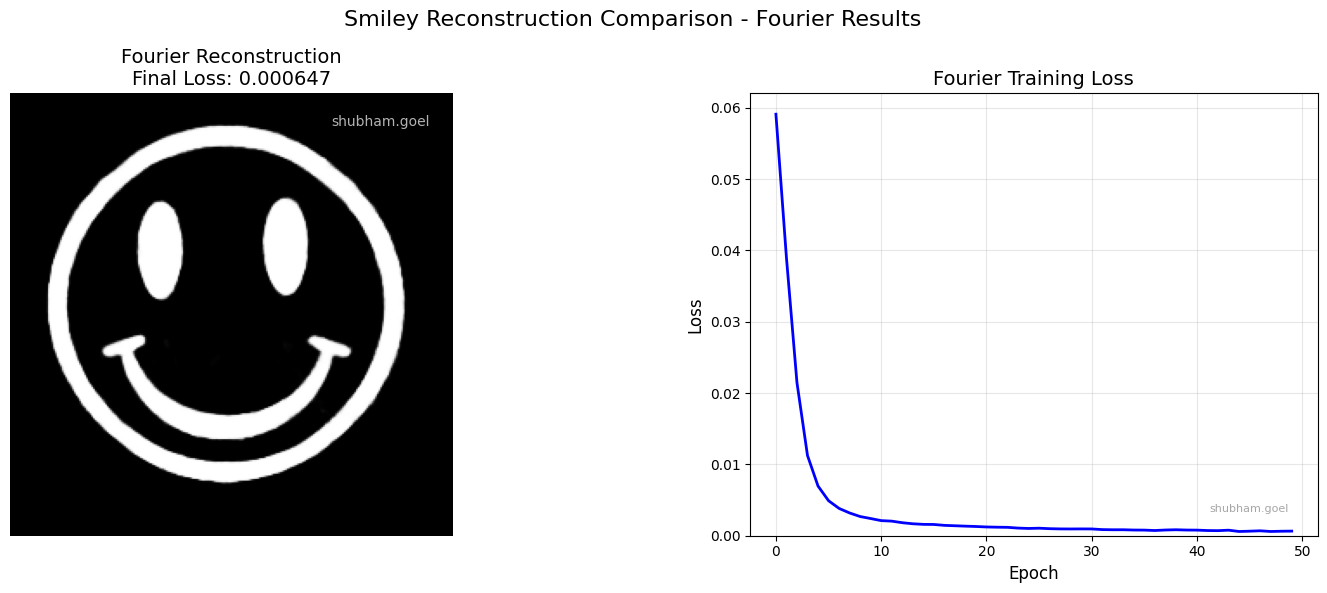

Fourier: Final Loss = 0.000647, Epochs = 50


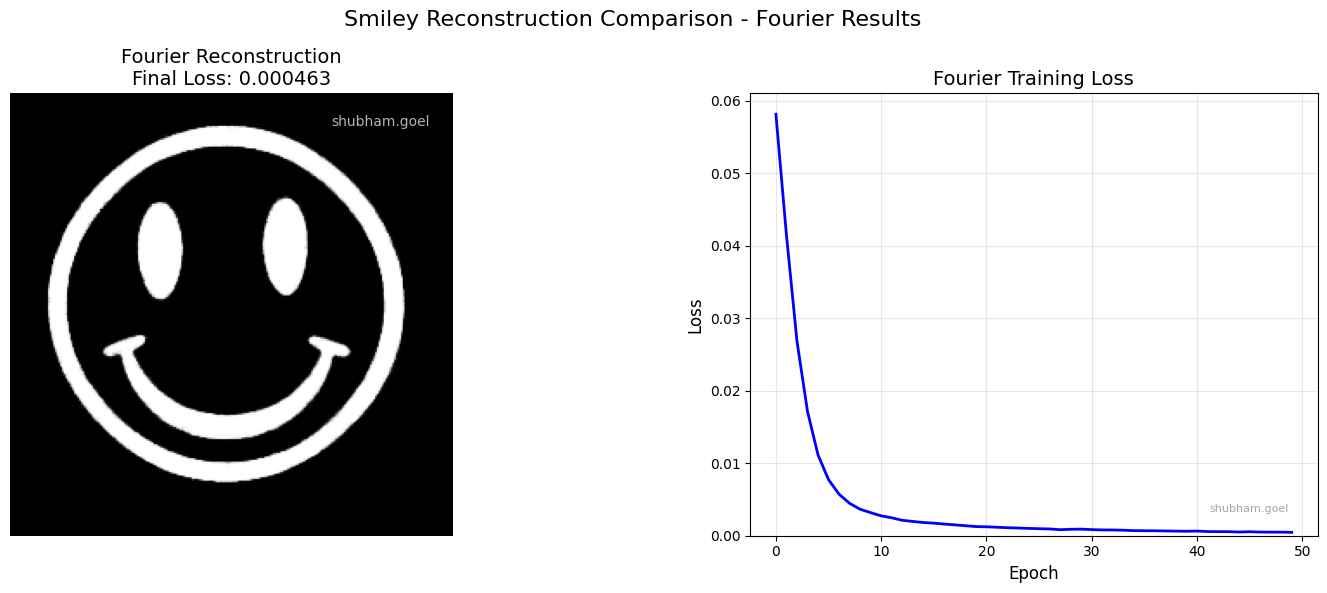

Fourier: Final Loss = 0.000463, Epochs = 50


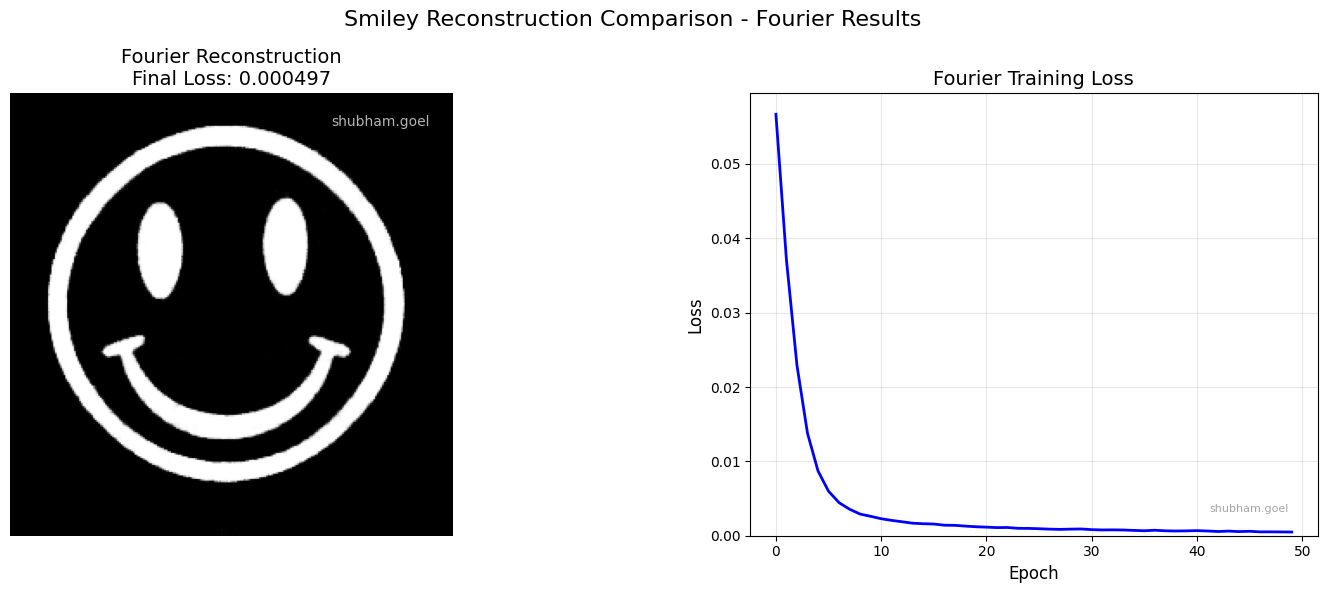

Fourier: Final Loss = 0.000497, Epochs = 50


=== MODEL COMPARISON TABLE ===
               Method  Final Loss  Avg Epoch Time (s)  Input Parameters
                  Raw    0.046990            1.810425                 2
 Polynomial (order=5)    0.003073            2.058191                20
Polynomial (order=15)    0.003501            2.277050               135
Polynomial (order=25)    0.003885            3.062657               350
     Fourier (freq=5)    0.000647            1.828481                21
    Fourier (freq=15)    0.000463            1.914950                61
    Fourier (freq=25)    0.000497            2.018052               101


In [33]:
# Visualize results
visualize_reconstruction_comparison(smiley_img, smiley_results, "Smiley Reconstruction Comparison")

## CAT - 150 epochs

In [34]:
print("=== TRAINING ON CAT IMAGE ===")

# Create dataloaders for cat (RGB)
cat_raw = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Raw')
cat_poly5 = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Polynomial', order=5)
cat_poly15 = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Polynomial', order=15)
cat_poly25 = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Polynomial', order=25)
cat_fourier5 = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Fourier', freq=5)
cat_fourier15 = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Fourier', freq=15)
cat_fourier25 = Modular_Dataloader('dataset/Q2/cat_resized.jpg', 'RGB', 'Fourier', freq=25)

# Train all methods (150 epochs)
cat_results = []

=== TRAINING ON CAT IMAGE ===


In [35]:
print("\n1. Training Raw method...")
cat_result_raw = train_image_reconstruction(cat_raw, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_raw")
cat_results.append(cat_result_raw)


1. Training Raw method...
MLP Architecture: 2 -> 64 -> 128 -> 128 -> 3
Total parameters: 25411
Training Raw method for 150 epochs...
Epoch 1/150: Loss = 0.027888, Time = 1.74s
Epoch 11/150: Loss = 0.009383, Time = 1.74s
Epoch 21/150: Loss = 0.008558, Time = 1.74s
Epoch 31/150: Loss = 0.008087, Time = 1.75s
Epoch 41/150: Loss = 0.007665, Time = 1.71s
Epoch 51/150: Loss = 0.007327, Time = 1.72s
Epoch 61/150: Loss = 0.007054, Time = 1.86s
Epoch 71/150: Loss = 0.006828, Time = 1.73s
Epoch 81/150: Loss = 0.006627, Time = 1.72s
Epoch 91/150: Loss = 0.006458, Time = 1.85s
Epoch 101/150: Loss = 0.006297, Time = 1.71s
Epoch 111/150: Loss = 0.006151, Time = 1.71s
Epoch 121/150: Loss = 0.006036, Time = 1.75s
Epoch 131/150: Loss = 0.005936, Time = 1.76s
Epoch 141/150: Loss = 0.005843, Time = 1.73s
Epoch 150/150: Loss = 0.005773, Time = 1.73s
Training completed! Final loss: 0.005773
Total time: 363.37s, Avg epoch time: 1.74s


In [36]:

print("\n2. Training Polynomial order=5...")
cat_result_poly5 = train_image_reconstruction(cat_poly5, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_poly5")
cat_results.append(cat_result_poly5)


2. Training Polynomial order=5...
MLP Architecture: 20 -> 64 -> 128 -> 128 -> 3
Total parameters: 26563
Training Polynomial method for 150 epochs...
Epoch 1/150: Loss = 0.013180, Time = 1.79s
Epoch 11/150: Loss = 0.006504, Time = 1.78s
Epoch 21/150: Loss = 0.006100, Time = 1.79s
Epoch 31/150: Loss = 0.005885, Time = 1.76s
Epoch 41/150: Loss = 0.005689, Time = 1.80s
Epoch 51/150: Loss = 0.005527, Time = 1.80s
Epoch 61/150: Loss = 0.005377, Time = 1.78s
Epoch 71/150: Loss = 0.005244, Time = 1.80s
Epoch 81/150: Loss = 0.005119, Time = 1.79s
Epoch 91/150: Loss = 0.005007, Time = 1.80s
Epoch 101/150: Loss = 0.004895, Time = 1.79s
Epoch 111/150: Loss = 0.004780, Time = 1.78s
Epoch 121/150: Loss = 0.004688, Time = 1.76s
Epoch 131/150: Loss = 0.004610, Time = 1.78s
Epoch 141/150: Loss = 0.004524, Time = 1.76s
Epoch 150/150: Loss = 0.004449, Time = 1.76s
Training completed! Final loss: 0.004449
Total time: 371.80s, Avg epoch time: 1.78s


In [37]:
print("\n3. Training Polynomial order=15...")
cat_result_poly15 = train_image_reconstruction(cat_poly15, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_poly15")
cat_results.append(cat_result_poly15)


3. Training Polynomial order=15...
MLP Architecture: 135 -> 64 -> 128 -> 128 -> 3
Total parameters: 33923
Training Polynomial method for 150 epochs...
Epoch 1/150: Loss = 0.013324, Time = 2.02s
Epoch 11/150: Loss = 0.006613, Time = 2.03s
Epoch 21/150: Loss = 0.006221, Time = 2.02s
Epoch 31/150: Loss = 0.006030, Time = 2.03s
Epoch 41/150: Loss = 0.005869, Time = 2.04s
Epoch 51/150: Loss = 0.005737, Time = 2.06s
Epoch 61/150: Loss = 0.005597, Time = 2.07s
Epoch 71/150: Loss = 0.005464, Time = 2.02s
Epoch 81/150: Loss = 0.005339, Time = 2.02s
Epoch 91/150: Loss = 0.005232, Time = 2.02s
Epoch 101/150: Loss = 0.005113, Time = 2.02s
Epoch 111/150: Loss = 0.004995, Time = 2.06s
Epoch 121/150: Loss = 0.004904, Time = 2.07s
Epoch 131/150: Loss = 0.004813, Time = 2.07s
Epoch 141/150: Loss = 0.004723, Time = 2.08s
Epoch 150/150: Loss = 0.004652, Time = 2.04s
Training completed! Final loss: 0.004652
Total time: 420.92s, Avg epoch time: 2.04s


In [38]:
print("\n4. Training Polynomial order=25...")
cat_result_poly25 = train_image_reconstruction(cat_poly25, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_poly25")
cat_results.append(cat_result_poly25)


4. Training Polynomial order=25...
MLP Architecture: 350 -> 64 -> 128 -> 128 -> 3
Total parameters: 47683
Training Polynomial method for 150 epochs...
Epoch 1/150: Loss = 0.013672, Time = 2.57s
Epoch 11/150: Loss = 0.006798, Time = 2.55s
Epoch 21/150: Loss = 0.006354, Time = 2.54s
Epoch 31/150: Loss = 0.006162, Time = 2.52s
Epoch 41/150: Loss = 0.006006, Time = 2.53s
Epoch 51/150: Loss = 0.005876, Time = 2.59s
Epoch 61/150: Loss = 0.005736, Time = 2.56s
Epoch 71/150: Loss = 0.005596, Time = 2.55s
Epoch 81/150: Loss = 0.005464, Time = 2.57s
Epoch 91/150: Loss = 0.005350, Time = 2.55s
Epoch 101/150: Loss = 0.005244, Time = 2.58s
Epoch 111/150: Loss = 0.005118, Time = 2.58s
Epoch 121/150: Loss = 0.005015, Time = 2.58s
Epoch 131/150: Loss = 0.004910, Time = 2.57s
Epoch 141/150: Loss = 0.004801, Time = 2.59s
Epoch 150/150: Loss = 0.004703, Time = 2.56s
Training completed! Final loss: 0.004703
Total time: 512.81s, Avg epoch time: 2.56s


In [39]:
print("\n5. Training Fourier freq=5...")
cat_result_fourier5 = train_image_reconstruction(cat_fourier5, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_fourier5")
cat_results.append(cat_result_fourier5)


5. Training Fourier freq=5...
MLP Architecture: 21 -> 64 -> 128 -> 128 -> 3
Total parameters: 26627
Training Fourier method for 150 epochs...
Epoch 1/150: Loss = 0.016134, Time = 1.82s
Epoch 11/150: Loss = 0.004160, Time = 1.78s
Epoch 21/150: Loss = 0.003434, Time = 1.78s
Epoch 31/150: Loss = 0.003147, Time = 1.80s
Epoch 41/150: Loss = 0.002972, Time = 1.80s
Epoch 51/150: Loss = 0.002871, Time = 1.78s
Epoch 61/150: Loss = 0.002765, Time = 1.76s
Epoch 71/150: Loss = 0.002694, Time = 1.77s
Epoch 81/150: Loss = 0.002643, Time = 1.78s
Epoch 91/150: Loss = 0.002588, Time = 1.80s
Epoch 101/150: Loss = 0.002534, Time = 1.79s
Epoch 111/150: Loss = 0.002489, Time = 1.77s
Epoch 121/150: Loss = 0.002454, Time = 1.77s
Epoch 131/150: Loss = 0.002429, Time = 1.77s
Epoch 141/150: Loss = 0.002391, Time = 1.75s
Epoch 150/150: Loss = 0.002373, Time = 1.79s
Training completed! Final loss: 0.002373
Total time: 375.13s, Avg epoch time: 1.78s


In [40]:

print("\n6. Training Fourier freq=15...")
cat_result_fourier15 = train_image_reconstruction(cat_fourier15, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_fourier15")
cat_results.append(cat_result_fourier15)


6. Training Fourier freq=15...
MLP Architecture: 61 -> 64 -> 128 -> 128 -> 3
Total parameters: 29187
Training Fourier method for 150 epochs...
Epoch 1/150: Loss = 0.016902, Time = 1.86s
Epoch 11/150: Loss = 0.004665, Time = 1.85s
Epoch 21/150: Loss = 0.003548, Time = 1.85s
Epoch 31/150: Loss = 0.003074, Time = 1.84s
Epoch 41/150: Loss = 0.002804, Time = 1.85s
Epoch 51/150: Loss = 0.002651, Time = 1.89s
Epoch 61/150: Loss = 0.002501, Time = 1.88s
Epoch 71/150: Loss = 0.002399, Time = 1.86s
Epoch 81/150: Loss = 0.002314, Time = 1.86s
Epoch 91/150: Loss = 0.002242, Time = 1.89s
Epoch 101/150: Loss = 0.002177, Time = 1.85s
Epoch 111/150: Loss = 0.002118, Time = 1.88s
Epoch 121/150: Loss = 0.002067, Time = 1.87s
Epoch 131/150: Loss = 0.002026, Time = 1.88s
Epoch 141/150: Loss = 0.001984, Time = 1.89s
Epoch 150/150: Loss = 0.001953, Time = 1.90s
Training completed! Final loss: 0.001953
Total time: 390.78s, Avg epoch time: 1.87s


In [41]:
print("\n7. Training Fourier freq=25...")
cat_result_fourier25 = train_image_reconstruction(cat_fourier25, num_epochs=150, batch_size=16,save_epochs=True, dir_name="results/cat_fourier25")
cat_results.append(cat_result_fourier25)


7. Training Fourier freq=25...
MLP Architecture: 101 -> 64 -> 128 -> 128 -> 3
Total parameters: 31747
Training Fourier method for 150 epochs...
Epoch 1/150: Loss = 0.015589, Time = 1.95s
Epoch 11/150: Loss = 0.004429, Time = 1.97s
Epoch 21/150: Loss = 0.003400, Time = 1.96s
Epoch 31/150: Loss = 0.002965, Time = 1.96s
Epoch 41/150: Loss = 0.002718, Time = 1.96s
Epoch 51/150: Loss = 0.002575, Time = 1.97s
Epoch 61/150: Loss = 0.002442, Time = 1.98s
Epoch 71/150: Loss = 0.002347, Time = 1.96s
Epoch 81/150: Loss = 0.002270, Time = 1.96s
Epoch 91/150: Loss = 0.002201, Time = 1.98s
Epoch 101/150: Loss = 0.002132, Time = 1.98s
Epoch 111/150: Loss = 0.002081, Time = 2.12s
Epoch 121/150: Loss = 0.002029, Time = 1.97s
Epoch 131/150: Loss = 0.001991, Time = 1.94s
Epoch 141/150: Loss = 0.001952, Time = 1.94s
Epoch 150/150: Loss = 0.001921, Time = 1.94s
Training completed! Final loss: 0.001921
Total time: 411.59s, Avg epoch time: 1.98s


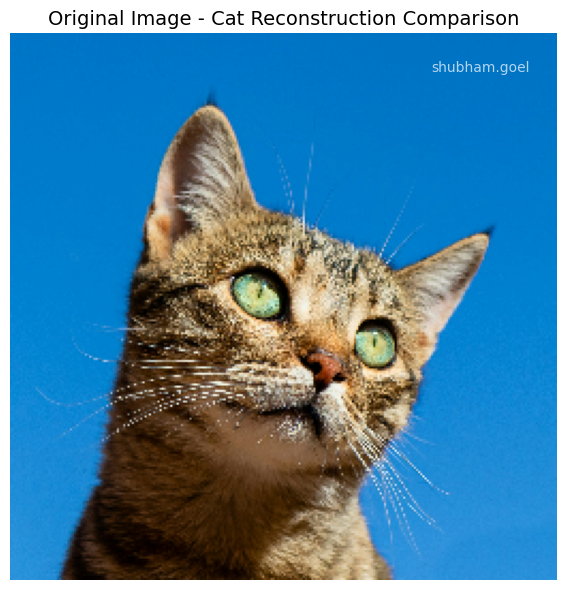

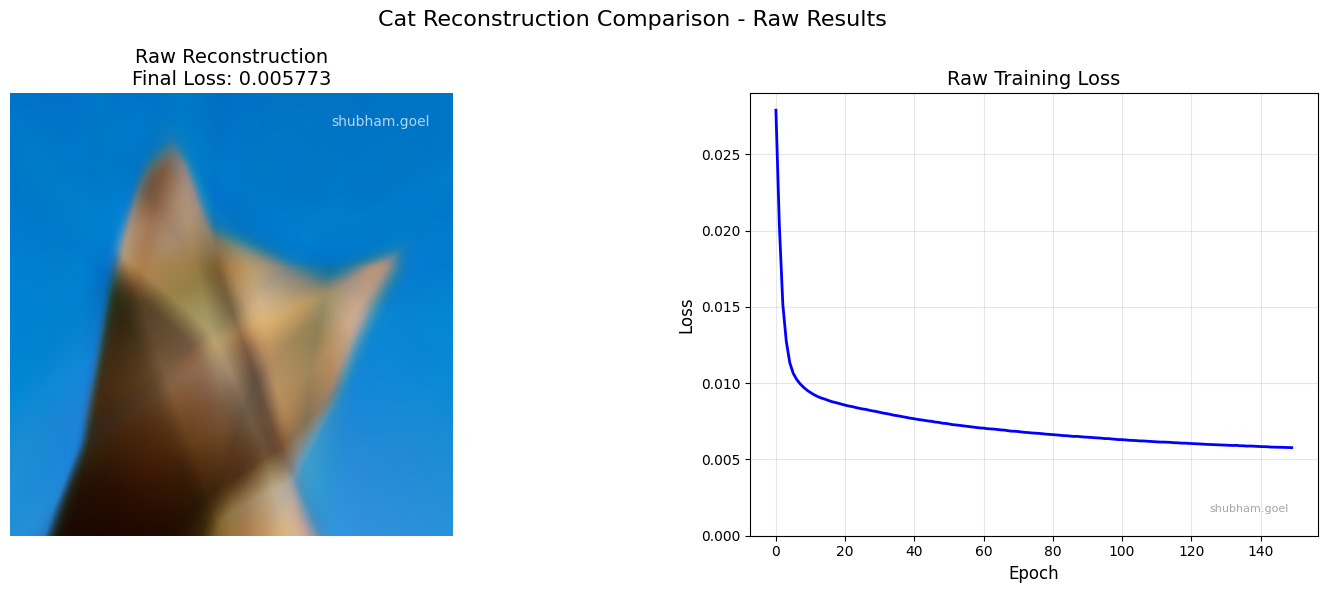

Raw: Final Loss = 0.005773, Epochs = 150


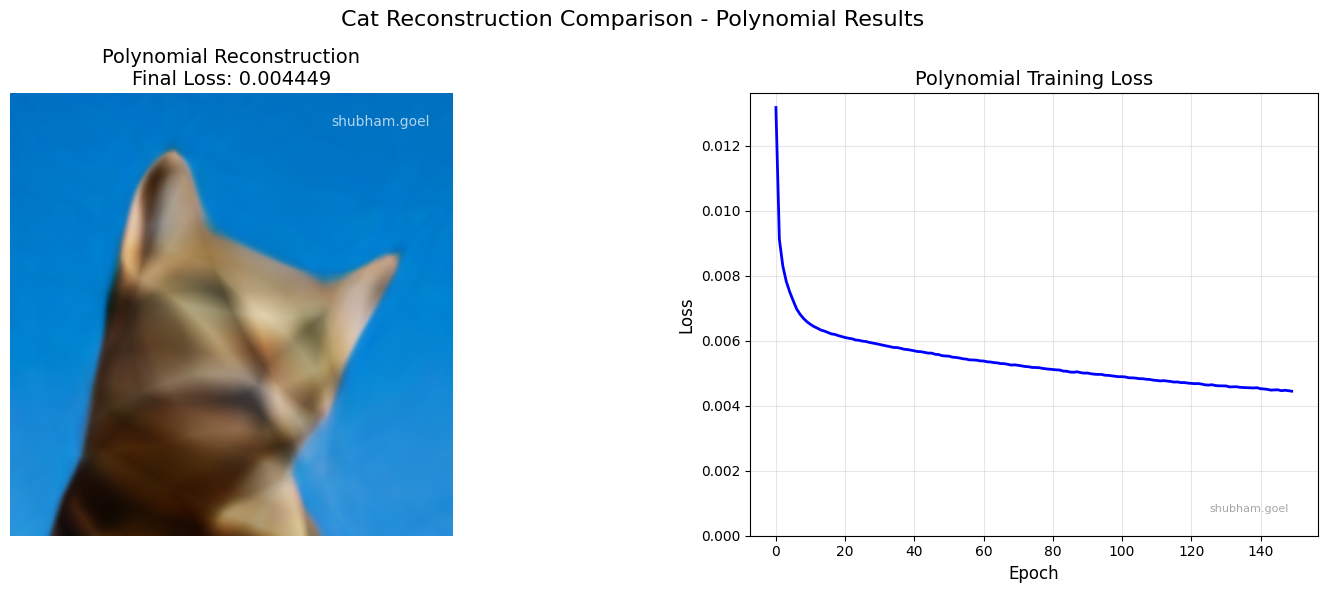

Polynomial: Final Loss = 0.004449, Epochs = 150


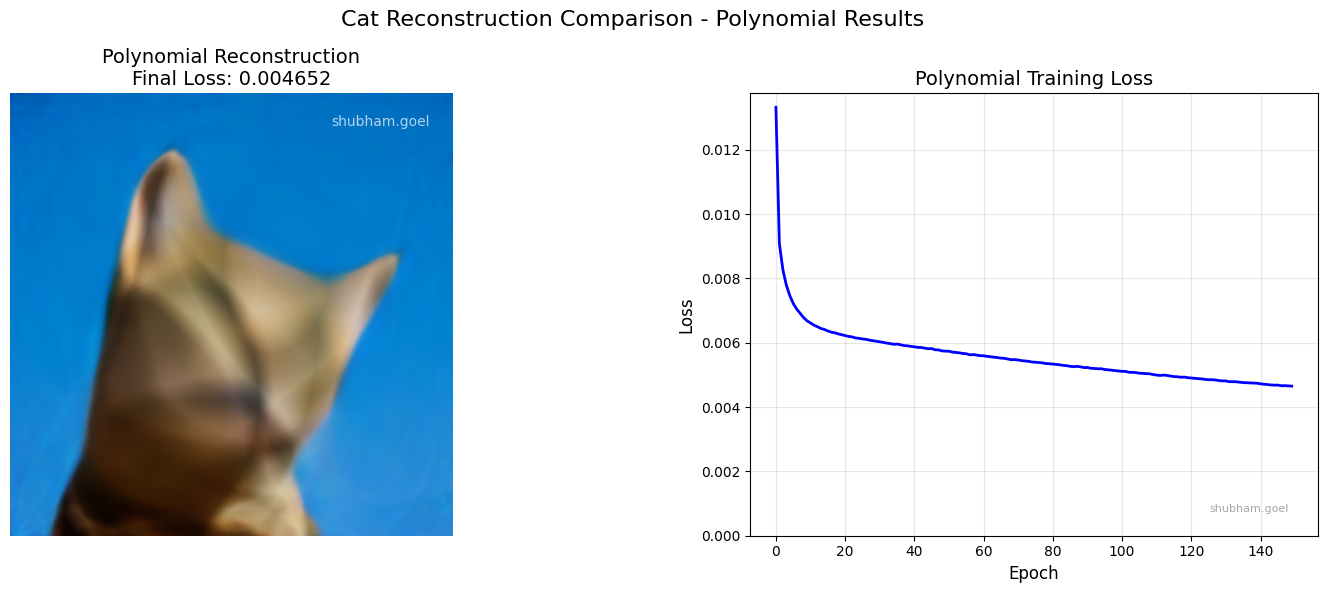

Polynomial: Final Loss = 0.004652, Epochs = 150


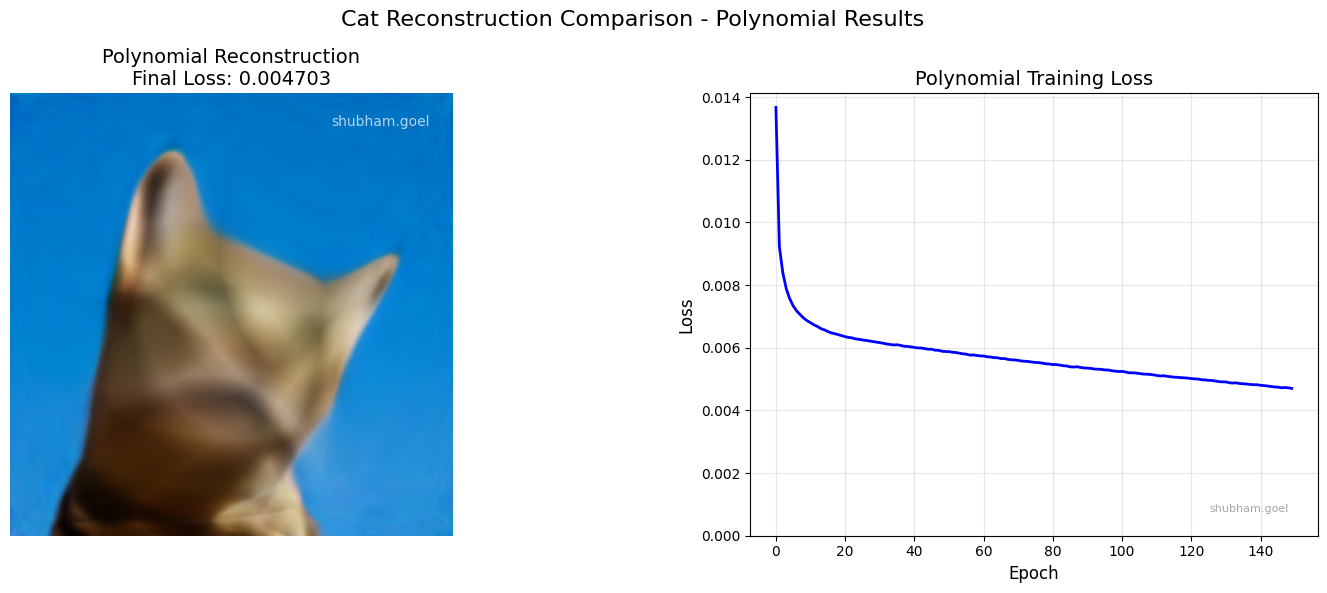

Polynomial: Final Loss = 0.004703, Epochs = 150


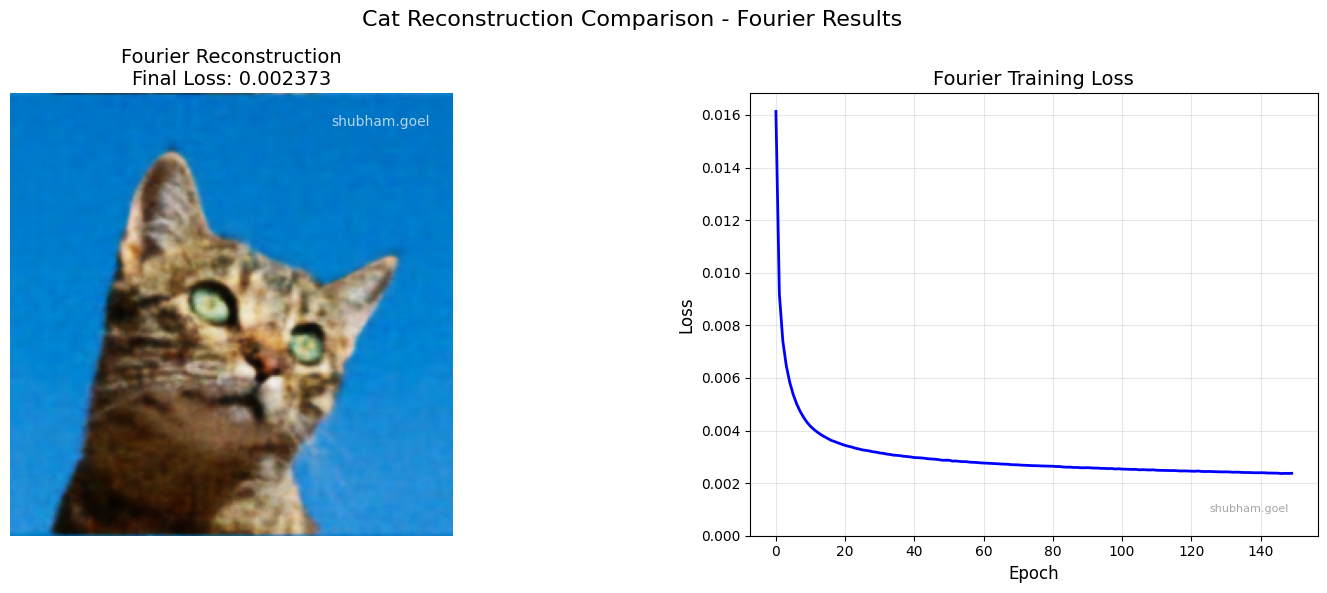

Fourier: Final Loss = 0.002373, Epochs = 150


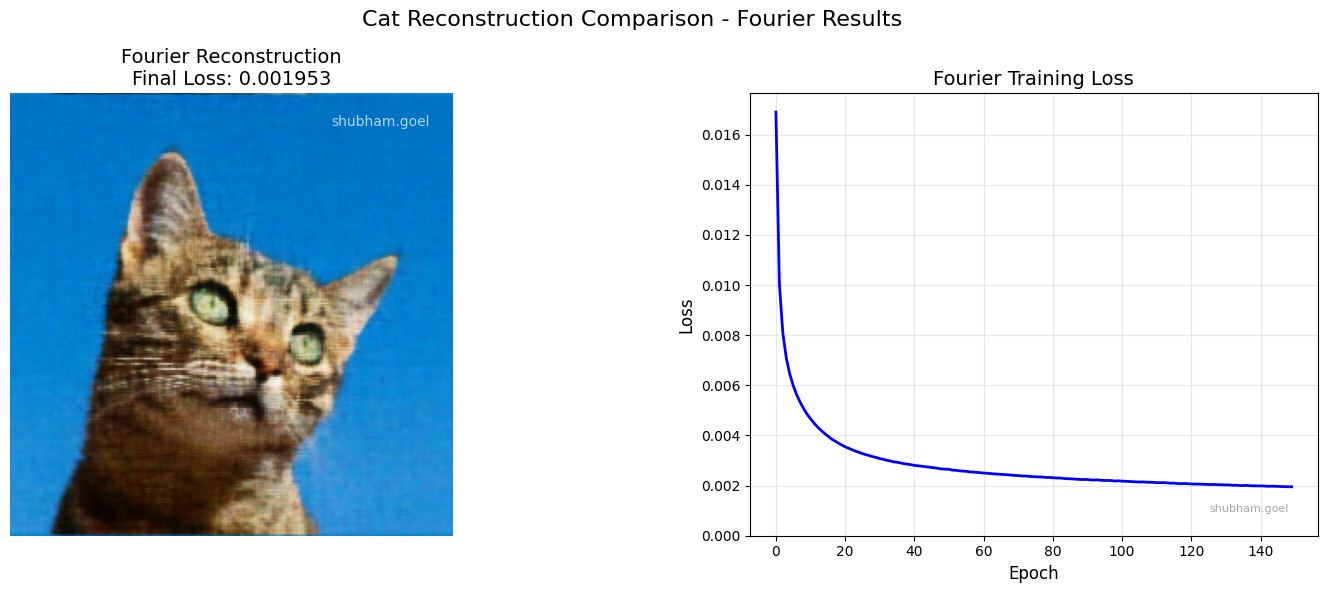

Fourier: Final Loss = 0.001953, Epochs = 150


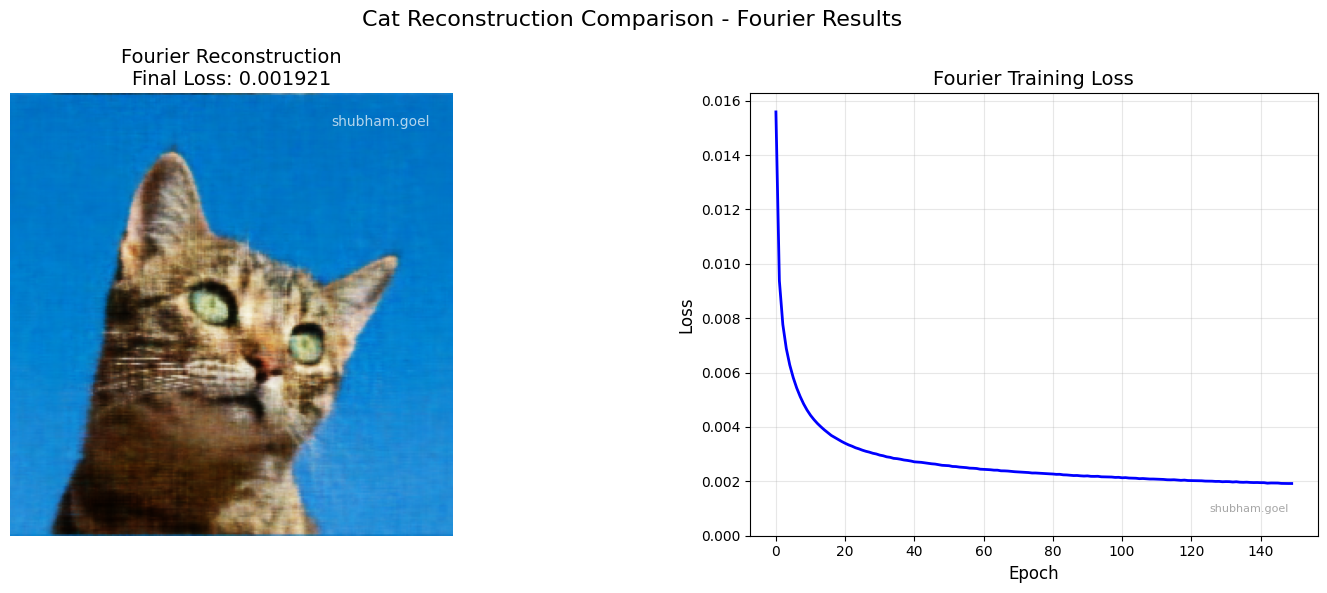

Fourier: Final Loss = 0.001921, Epochs = 150


=== MODEL COMPARISON TABLE ===
               Method  Final Loss  Avg Epoch Time (s)  Input Parameters
                  Raw    0.005773            1.742179                 2
 Polynomial (order=5)    0.004449            1.775263                20
Polynomial (order=15)    0.004652            2.043055               135
Polynomial (order=25)    0.004703            2.559732               350
     Fourier (freq=5)    0.002373            1.784540                21
    Fourier (freq=15)    0.001953            1.868472                61
    Fourier (freq=25)    0.001921            1.975897               101


In [42]:
# Visualize results
visualize_reconstruction_comparison(cat_img, cat_results, "Cat Reconstruction Comparison")

## GIF

In [43]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def create_training_gif(raw_result, poly_result, fourier_result, output_name, original_img):
    """
    Create GIF showing training progression for three methods side by side.
    Adjusted so loss plots have more vertical space (not squeezed).
    """
    print(f"Creating training GIF: {output_name}")

    raw_images = raw_result.get('saved_images', [])
    poly_images = poly_result.get('saved_images', [])
    fourier_images = fourier_result.get('saved_images', [])

    raw_losses = raw_result.get('losses', [])
    poly_losses = poly_result.get('losses', [])
    fourier_losses = fourier_result.get('losses', [])

    # number of frames: longest sequence among methods
    num_epochs = max(len(raw_images), len(poly_images), len(fourier_images))
    if num_epochs == 0:
        print("No frames to render.")
        return

    # stable y-limits for loss plots
    all_losses = raw_losses + poly_losses + fourier_losses
    max_loss = float(max(all_losses)) if len(all_losses) else 1.0
    ylim_top = max_loss * 1.05 if max_loss > 0 else 1.0
    ylim_top = max(ylim_top, 1e-6)

    gif_frames = []
    tmp_files = []

    # Use gridspec with larger top row for images and increased overall height
    for epoch in range(num_epochs):
        fig, axes = plt.subplots(
            nrows=2, ncols=3,
            figsize=(18, 13),  # taller figure to allocate more space to loss row
            gridspec_kw={'height_ratios': [3, 1.6], 'wspace': 0.25, 'hspace': 0.35}
        )

        titles = ['Raw', 'Polynomial', 'Fourier']
        imgs = [
            raw_images[epoch] if epoch < len(raw_images) else raw_images[-1],
            poly_images[epoch] if epoch < len(poly_images) else poly_images[-1],
            fourier_images[epoch] if epoch < len(fourier_images) else fourier_images[-1]
        ]
        losses_lists = [
            raw_losses[:epoch+1],
            poly_losses[:epoch+1],
            fourier_losses[:epoch+1]
        ]
        colors = ['tab:blue', 'tab:green', 'tab:red']

        # Top row: reconstructions (large)
        for i, img in enumerate(imgs):
            ax = axes[0, i]
            if img is None:
                ax.axis('off')
                continue
            arr = np.array(img)

            # if image in 0..255 scale to 0..1
            if arr.dtype != np.float32 and arr.dtype != np.float64 and arr.max() > 1.5:
                arr = arr.astype(np.float32) / 255.0
            if arr.ndim == 2:
                ax.imshow(arr, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
            else:
                ax.imshow(np.clip(arr, 0, 1), interpolation='nearest')

            ax.set_title(f'{titles[i]} - Epoch {epoch+1}', fontsize=12)
            ax.axis('off')
            ax.set_aspect('equal')

            try:
                ax.text(0.98, 0.02, USERNAME, ha='right', va='bottom', transform=ax.transAxes,
                        fontsize=9, color='white', alpha=0.9)
            except Exception:
                pass

        # Bottom row: loss plots with fixed x and y limits
        x_axis = np.arange(1, num_epochs + 1)
        for i, (loss_hist, title, color) in enumerate(zip(losses_lists, titles, colors)):
            ax = axes[1, i]

            # Draw full x-axis grid first (empty), then overlay curve so width is stable
            ax.plot(x_axis, [None] * len(x_axis), alpha=0)  # creates the x range
            if len(loss_hist) > 0:
                ax.plot(np.arange(1, len(loss_hist) + 1), loss_hist, color=color, linewidth=2)

            ax.set_xlim(1, max(1, num_epochs))
            ax.set_ylim(0, ylim_top)
            ax.set_title(f'{title} Loss', fontsize=12)
            ax.set_xlabel('Epoch', fontsize=10)
            ax.set_ylabel('Loss', fontsize=10)
            ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

            try:
                ax.text(0.98, 0.98, USERNAME, ha='right', va='top', transform=ax.transAxes,
                        fontsize=8, color='gray', alpha=0.8)
            except Exception:
                pass

            # improve spacing inside loss axes so plot area is not squeezed
            ax.margins(x=0.02, y=0.05)

        # tighten layout but keep space for suptitle
        plt.suptitle(f'Training Progress - Epoch {epoch+1}/{num_epochs}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save to a temporary PNG
        fd, tmp_path = tempfile.mkstemp(suffix='.png')
        os.close(fd)
        tmp_files.append(tmp_path)
        plt.savefig(tmp_path, dpi=150, bbox_inches='tight')
        plt.close(fig)

        # load frame and append
        frame = Image.open(tmp_path).convert('RGBA')
        gif_frames.append(frame)

    # Save GIF
    if len(gif_frames) > 0:
        gif_frames[0].save(
            output_name,
            save_all=True,
            append_images=gif_frames[1:],
            duration=300,
            loop=0,
            optimize=False,
            quality=95
        )

    # cleanup tmp files
    for p in tmp_files:
        try:
            os.remove(p)
        except Exception:
            pass

    print(f"GIF saved as {output_name})")




# Create GIFs for both images
print("=== CREATING TRAINING GIFS ===")

# Select best performing methods for GIF
# For smiley: Raw, Polynomial order=15, Fourier freq=15
smiley_gif_raw = result_raw
smiley_gif_poly = result_poly15  
smiley_gif_fourier = result_fourier15

create_training_gif(
    smiley_gif_raw, smiley_gif_poly, smiley_gif_fourier,
    'smiley_training_progression.gif',
    smiley_img
)

# For cat: Raw, Polynomial order=15, Fourier freq=15  
cat_gif_raw = cat_result_raw
cat_gif_poly = cat_result_poly15
cat_gif_fourier = cat_result_fourier15

create_training_gif(
    cat_gif_raw, cat_gif_poly, cat_gif_fourier,
    'cat_training_progression.gif', 
    cat_img
)

print("Training GIFs created successfully!")

=== CREATING TRAINING GIFS ===
Creating training GIF: smiley_training_progression.gif


/ssd_scratch/shubham/tmp/ipykernel_3271186/2335380442.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


GIF saved as smiley_training_progression.gif)
Creating training GIF: cat_training_progression.gif
GIF saved as cat_training_progression.gif)
Training GIFs created successfully!


# Reconstruction on Blurred images

In [12]:
def train_with_early_stopping(dataloader, max_epochs=100, patience=10, relative_loss_threshold=1e-5):
    """
    Train MLP with early stopping for blur analysis.

    Args:
        dataloader: Modular_Dataloader instance
        max_epochs: Maximum number of epochs
        patience: Number of epochs to wait for improvement
        relative_loss_threshold: Relative improvement threshold for early stopping

    Returns:
        dict: Training results
    """
    features, targets = dataloader.get_data()
    info = dataloader.get_info()

    mlp = ImageReconstructionMLP(
        input_dim=info['input_dim'],
        output_dim=info['output_dim'],
        hidden_sizes=[64, 128, 128],
        learning_rate=0.5
    )

    num_samples = len(features)
    batch_size = 16

    epoch_losses = []
    grad_accumulation_steps = 1

    for epoch in range(max_epochs):
        epoch_loss = 0
        num_batches = 0

        indices = np.random.permutation(num_samples)

        for batch_start in range(0, num_samples, batch_size):
            batch_end = min(batch_start + batch_size, num_samples)
            batch_idx = indices[batch_start:batch_end]

            batch_features = features[batch_idx]
            batch_targets = targets[batch_idx]

            loss = mlp.train_step(batch_features, batch_targets)
            epoch_loss += loss
            num_batches += 1

            if (num_batches % grad_accumulation_steps) == 0:
                mlp.update_parameters(grad_accumulation_steps)



        if (num_batches % grad_accumulation_steps) != 0:
            mlp.update_parameters(grad_accumulation_steps)

        avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
        epoch_losses.append(avg_epoch_loss)


        # Early stopping check using relative improvement over (patience+1)-th previous epoch
        if len(epoch_losses) > patience:
            recent_loss = avg_epoch_loss
            past_loss = epoch_losses[-(patience + 1)]
            if recent_loss >= (1 - relative_loss_threshold) * past_loss:
                print(f"Early stopping at epoch {epoch+1} (no sufficient relative improvement over last {patience} epochs).")
                break


        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == max_epochs - 1:
            print(f"Epoch {epoch+1}/{max_epochs}: Avg Loss = {avg_epoch_loss:.8f}")

    final_predictions = mlp.predict(features)
    final_reconstruction = dataloader.reconstruct_image(final_predictions)

    results = {
        'method': info['method'],
        'final_loss': epoch_losses[-1],
        'losses': epoch_losses,
        'final_reconstruction': final_reconstruction,
        'epochs_trained': len(epoch_losses),
    }

    return results

Loading blurred cat images...
  Loaded blur_0.png
  Loaded blur_1.png
  Loaded blur_2.png
  Loaded blur_3.png
  Loaded blur_4.png
  Loaded blur_5.png
  Loaded blur_6.png
  Loaded blur_7.png
  Loaded blur_8.png
  Loaded blur_9.png
Loaded 10 blurred images

=== SAMPLE BLURRED IMAGES ===


/ssd_scratch/shubham/tmp/ipykernel_3271186/695025576.py:46: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


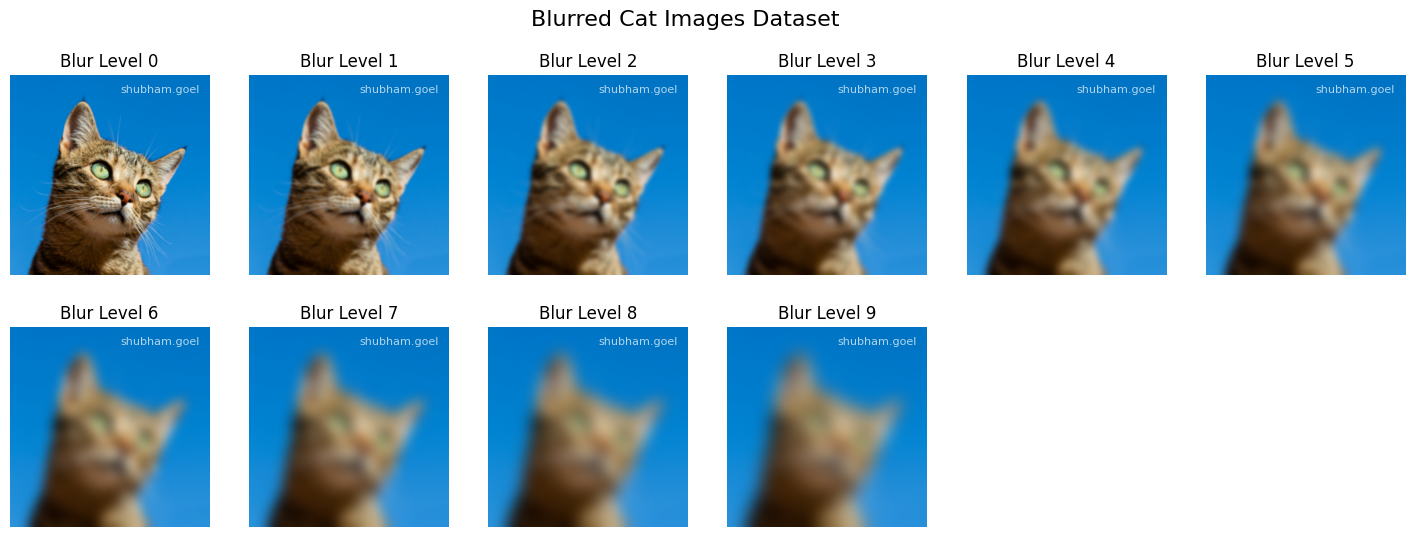

In [13]:

def load_blur_dataset():
    """Load all blurred cat images from the blurred folder."""
    
    blur_images = []
    blur_levels = []
    
    print("Loading blurred cat images...")
    
    for i in range(10):  # blur_0.png to blur_9.png
        img_path = f'dataset/Q2/blurred/blur_{i}.png'
        
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            img = img.resize((256, 256))
            img_array = np.array(img) / 255.0
            
            blur_images.append(img_array)
            blur_levels.append(i)
            print(f"  Loaded blur_{i}.png")
        else:
            print(f"  Warning: {img_path} not found")
    
    print(f"Loaded {len(blur_images)} blurred images")
    return blur_images, blur_levels



# Load blurred images
blur_images, blur_levels = load_blur_dataset()

print("\n=== SAMPLE BLURRED IMAGES ===")
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

for i in range(min(11, len(blur_images))):
    axes[i].imshow(blur_images[i])
    axes[i].set_title(f'Blur Level {blur_levels[i]}')
    axes[i].axis('off')
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top', 
             transform=axes[i].transAxes, fontsize=8, color='white', alpha=0.7)

for i in range(len(blur_images), 12):
    axes[i].axis('off')

plt.suptitle('Blurred Cat Images Dataset', fontsize=16)
plt.tight_layout()
plt.show()

# Training on Blurred dataset

In [14]:
print("=== TRAINING ON BLURRED IMAGES ===")

# Store results for analysis
blur_results_raw = []
blur_results_fourier = []

# Train on each blurred image
for i, (blur_img, blur_level) in enumerate(zip(blur_images, blur_levels)):
    
    print(f"\n--- Processing Blur Level {blur_level} ---")
    
    # Create temporary image file for dataloader
    temp_img_path = f'temp_blur_{blur_level}.png'
    blur_pil = Image.fromarray((blur_img * 255).astype(np.uint8))
    blur_pil.save(temp_img_path)
    
    try:
        # Create dataloaders for BASE (Raw) and FOURIER methods
        raw_loader = Modular_Dataloader(temp_img_path, 'RGB', 'Raw')
        fourier_loader = Modular_Dataloader(temp_img_path, 'RGB', 'Fourier', freq=5)
        
        print(f"Training BASE (Raw) method...")
        raw_result = train_with_early_stopping(raw_loader, max_epochs=100, patience=15)
        raw_result['blur_level'] = blur_level
        raw_result['original_image'] = blur_img
        blur_results_raw.append(raw_result)
        
        print(f"Training FOURIER method...")
        fourier_result = train_with_early_stopping(fourier_loader, max_epochs=100, patience=15)
        fourier_result['blur_level'] = blur_level
        fourier_result['original_image'] = blur_img
        blur_results_fourier.append(fourier_result)
        
        print(f"Blur {blur_level} completed:")
        print(f"  Raw - Loss: {raw_result['final_loss']:.8f}, Epochs: {raw_result['epochs_trained']}")
        print(f"  Fourier - Loss: {fourier_result['final_loss']:.8f}, Epochs: {fourier_result['epochs_trained']}")
        
    finally:
        # Clean up temporary file
        if os.path.exists(temp_img_path):
            os.remove(temp_img_path)



print("\n=== BLURRED IMAGE TRAINING COMPLETED ===")

# Extract data for analysis
blur_levels_array = np.array([r['blur_level'] for r in blur_results_raw])
raw_losses = np.array([r['final_loss'] for r in blur_results_raw])
fourier_losses = np.array([r['final_loss'] for r in blur_results_fourier])

print(f"\nProcessed {len(blur_levels_array)} blur levels")
print(f"Raw losses range: [{raw_losses.min():.8f}, {raw_losses.max():.8f}]")
print(f"Fourier losses range: [{fourier_losses.min():.8f}, {fourier_losses.max():.8f}]")

=== TRAINING ON BLURRED IMAGES ===

--- Processing Blur Level 0 ---
Training BASE (Raw) method...
MLP Architecture: 2 -> 64 -> 128 -> 128 -> 3
Total parameters: 25411
Epoch 1/100: Avg Loss = 0.02645919
Epoch 10/100: Avg Loss = 0.00797642
Epoch 20/100: Avg Loss = 0.00703319
Epoch 30/100: Avg Loss = 0.00653841
Epoch 40/100: Avg Loss = 0.00610408
Epoch 50/100: Avg Loss = 0.00577095
Epoch 60/100: Avg Loss = 0.00546117
Epoch 70/100: Avg Loss = 0.00521845
Epoch 80/100: Avg Loss = 0.00499646
Epoch 90/100: Avg Loss = 0.00481605
Epoch 100/100: Avg Loss = 0.00463533
Training FOURIER method...
MLP Architecture: 21 -> 64 -> 128 -> 128 -> 3
Total parameters: 26627
Epoch 1/100: Avg Loss = 0.01462526
Epoch 10/100: Avg Loss = 0.00273114
Epoch 20/100: Avg Loss = 0.00189058
Epoch 30/100: Avg Loss = 0.00157818
Epoch 40/100: Avg Loss = 0.00139773
Epoch 50/100: Avg Loss = 0.00128064
Epoch 60/100: Avg Loss = 0.00119398
Epoch 70/100: Avg Loss = 0.00113064
Epoch 80/100: Avg Loss = 0.00107993
Epoch 90/100: Avg

## Analysis and Visualization on Blur Results

=== BLUR ANALYSIS VISUALIZATION ===


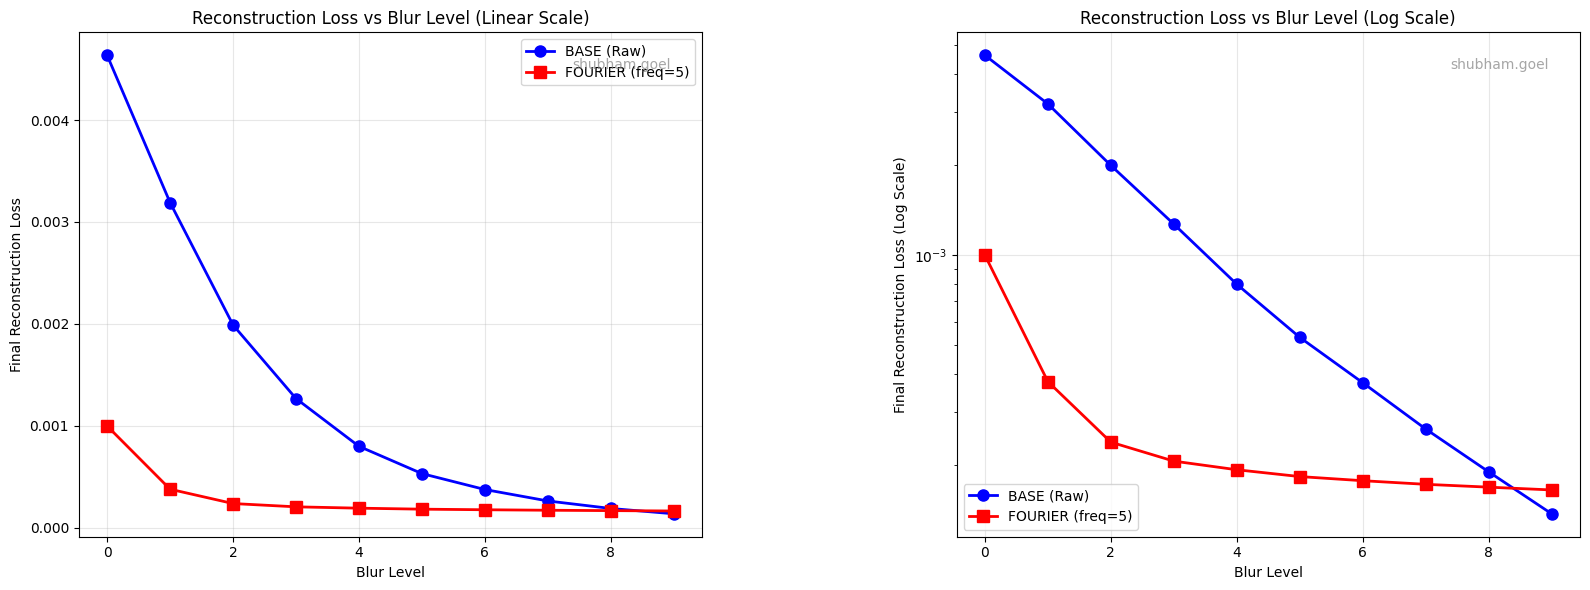

In [15]:
# Plot reconstruction loss vs blur level
print("=== BLUR ANALYSIS VISUALIZATION ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale plot
ax1.plot(blur_levels_array, raw_losses, 'b-o', label='BASE (Raw)', linewidth=2, markersize=8)
ax1.plot(blur_levels_array, fourier_losses, 'r-s', label='FOURIER (freq=5)', linewidth=2, markersize=8)
ax1.set_xlabel('Blur Level')
ax1.set_ylabel('Final Reconstruction Loss')
ax1.set_title('Reconstruction Loss vs Blur Level (Linear Scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.text(0.95, 0.95, USERNAME, ha='right', va='top', 
         transform=ax1.transAxes, fontsize=10, color='gray', alpha=0.7)

# Logarithmic scale plot
ax2.semilogy(blur_levels_array, raw_losses, 'b-o', label='BASE (Raw)', linewidth=2, markersize=8)
ax2.semilogy(blur_levels_array, fourier_losses, 'r-s', label='FOURIER (freq=5)', linewidth=2, markersize=8)
ax2.set_xlabel('Blur Level')
ax2.set_ylabel('Final Reconstruction Loss (Log Scale)')
ax2.set_title('Reconstruction Loss vs Blur Level (Log Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.text(0.95, 0.95, USERNAME, ha='right', va='top', 
         transform=ax2.transAxes, fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()


=== ALL BLUR LEVEL RECONSTRUCTIONS ===


/ssd_scratch/shubham/tmp/ipykernel_3271186/3408772283.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


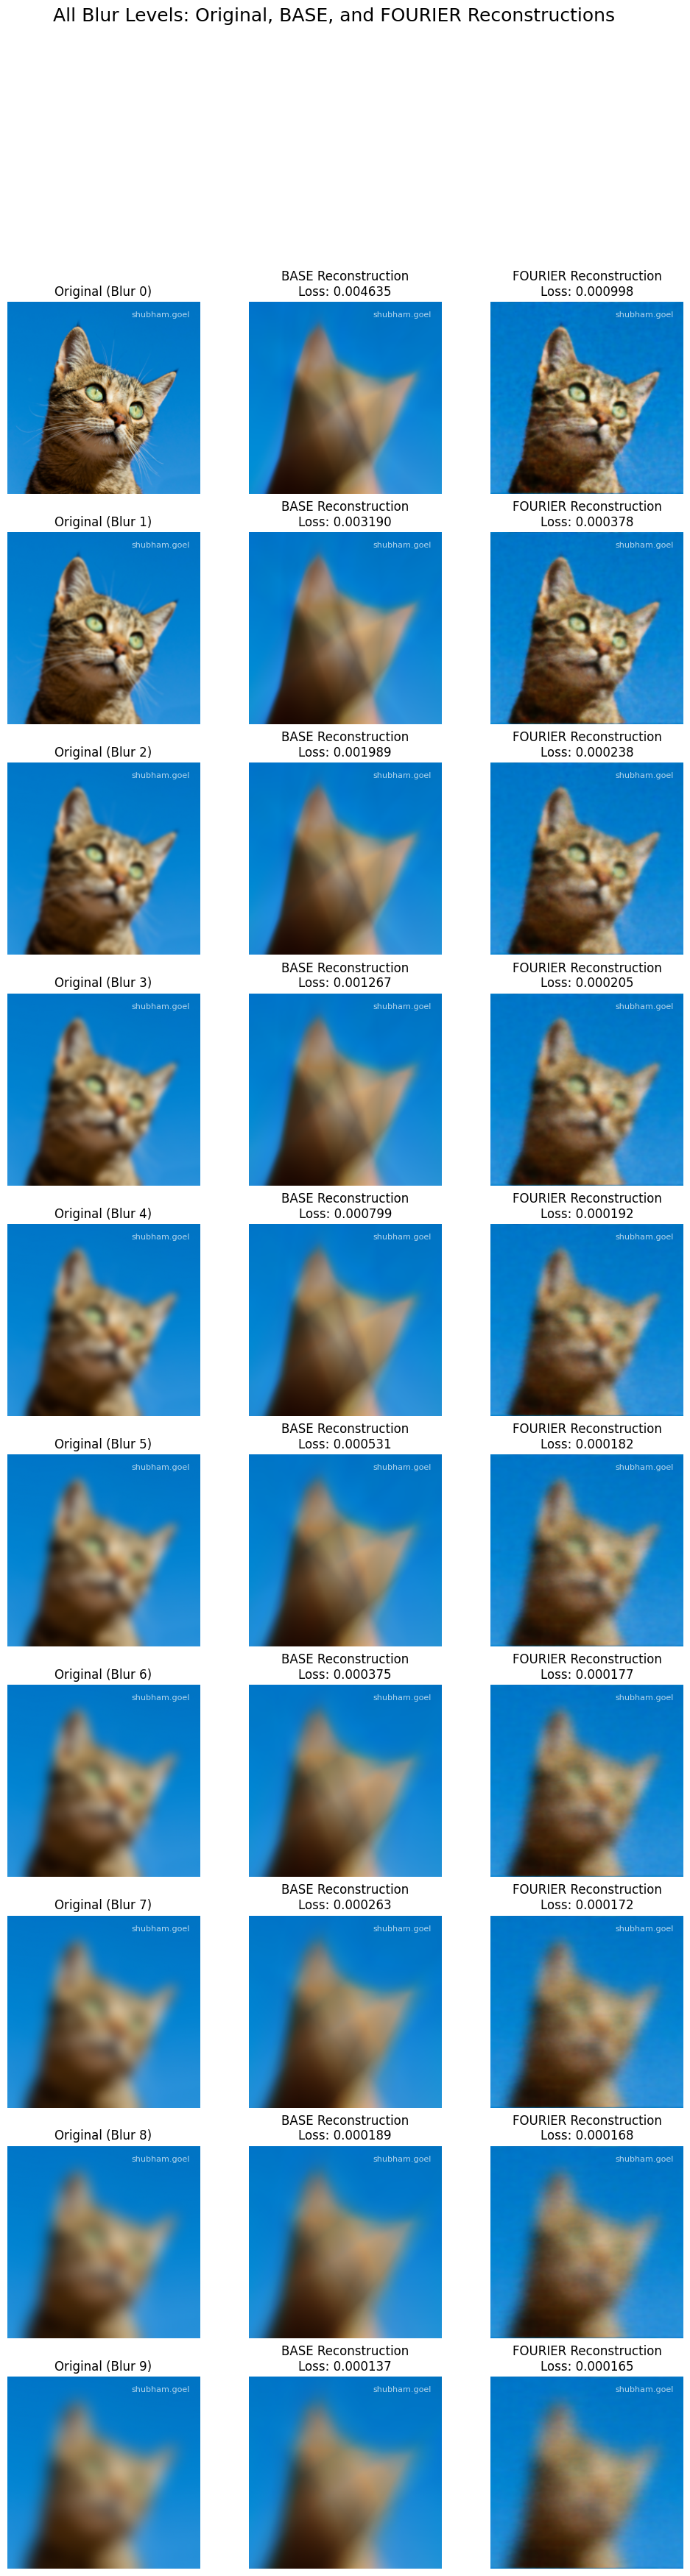

In [16]:
print("\n=== ALL BLUR LEVEL RECONSTRUCTIONS ===")

num_samples = len(blur_results_raw)
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    blur_level = blur_results_raw[i]['blur_level']
    original = blur_results_raw[i]['original_image']
    raw_recon = blur_results_raw[i]['final_reconstruction']
    fourier_recon = blur_results_fourier[i]['final_reconstruction']

    # Original blurred image (left)
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f'Original (Blur {blur_level})', fontsize=12)
    axes[i, 0].axis('off')
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
             transform=axes[i, 0].transAxes, fontsize=8, color='white', alpha=0.7)

    # Raw reconstruction (center)
    axes[i, 1].imshow(np.clip(raw_recon, 0, 1))
    axes[i, 1].set_title(f'BASE Reconstruction\nLoss: {blur_results_raw[i]["final_loss"]:.6f}', fontsize=12)
    axes[i, 1].axis('off')
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
             transform=axes[i, 1].transAxes, fontsize=8, color='white', alpha=0.7)

    # Fourier reconstruction (right)
    axes[i, 2].imshow(np.clip(fourier_recon, 0, 1))
    axes[i, 2].set_title(f'FOURIER Reconstruction\nLoss: {blur_results_fourier[i]["final_loss"]:.6f}', fontsize=12)
    axes[i, 2].axis('off')
    plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
             transform=axes[i, 2].transAxes, fontsize=8, color='white', alpha=0.7)

plt.suptitle('All Blur Levels: Original, BASE, and FOURIER Reconstructions', fontsize=18)
plt.tight_layout()
plt.show()

## Discussion

On blurred images, reconstruction quality improved as blur increased , confirming that smoothed images with fewer high frequencies are easier to approximate.